# Setup

In [1]:
%matplotlib inline

In [2]:
import phoebe
from phoebe import u,c

import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [3]:
logger = phoebe.logger(clevel='WARNING')

In [4]:
b = phoebe.default_binary()

# Atmospheres

Let's start by adding a dataset which probes only the secondary eclipse (as eclipses are where we will see the most dramatic deviations).  We'll specify the passband of the observation to be Johnson:V.

In [5]:
b.add_dataset('lc', times=np.linspace(0.3,0.7,101), dataset='lcV',passband='Johnson:V')

<ParameterSet: 15 parameters | contexts: compute, dataset>

To isolate only the effect of changing the atmosphere, we will temporarily turn off limb-darkening and gravity brightening. We can do this simultaneously for both stars using set_value_all.  Note that upon changing the limb-darkening function, PHOEBE might complain that the limb-darkening coefficients are not valid - this isn't a problem, it's just PHOEBE running checks before we've managed to set the coefficients.

In [6]:
b.set_value_all('ld_func','linear')
b.set_value_all('ld_coeffs',[0.])

Mon, 04 Jun 2018 10:07 PARAMETERS   WARNING ld_coeffs='[0.5 0.5]' inconsistent with ld_func='linear'
Mon, 04 Jun 2018 10:07 PARAMETERS   WARNING ld_coeffs='[0.5 0.5]' inconsistent with ld_func='linear'
Mon, 04 Jun 2018 10:08 PARAMETERS   WARNING ld_coeffs='[0.5 0.5]' inconsistent with ld_func='linear'
Mon, 04 Jun 2018 10:08 PARAMETERS   WARNING ld_coeffs='[0.5 0.5]' inconsistent with ld_func='linear'


In order to really see the differences between using model atmospheres and black bodies, we need to make the two starts different (in this case, we will change only the temperature of the secondary star) and then compute light curves using the two different atmosphere options.  Let's start with the default Castelli & Kurucz (2004) aka 'ck2004' atmospheres.

In [7]:
b['teff@secondary']=4000*u.K
b.run_compute(model='ck2004')

<ParameterSet: 2 parameters | qualifiers: fluxes, times>

Now let's switch to black body atmospheres and recompute

In [8]:
b.set_value_all('atm','blackbody')
b.run_compute(model='blackbody')

<ParameterSet: 2 parameters | qualifiers: fluxes, times>

Now, let's plot the two eclipses to see the differences.  Note that because the fluxes are normalised for the primary star (the only star visible during secondary eclipse), the eclipse bottoms are the same while the out of eclipse values are very different.

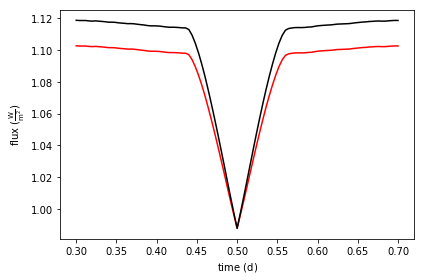

In [9]:
axs, artists = b.plot(model='ck2004',color='r')
axs, artists = b.plot(model='blackbody',color='k')

# Limb-darkening

Let's investigate different limb-darkening parameterisations using binary we've just created. First, we need to turn the atmospheres back to ck2004 (otherwise PHOEBE's native 'interp' limb-darkening won't be available)

In [10]:
b.set_value_all('atm','ck2004')

We are going to compare the results derived using PHOEBE's interpolated limb-darkening to those derived using a couple of different limb-darkening parameterisations.  Let's start with 'interp'

In [11]:
b.set_value_all('ld_func','interp')
b.run_compute(model='interp')

<ParameterSet: 2 parameters | qualifiers: fluxes, times>

To compare with other parameterisations, we need to find the corresponding values in a table.  The values for many passbands calculated by Claret & Bloemen (2011) are available via Vizier [here](http://vizier.cfa.harvard.edu/viz-bin/VizieR?-source=J/A+A/529/A75) (be careful to choose the right filter - Johnson V not Strömgren v).

In [12]:
b.set_value_all('ld_func','linear')
b.set_value('ld_coeffs@primary',[0.6])
b.set_value('ld_coeffs@secondary',[0.7])
b.run_compute(model='linear')

<ParameterSet: 2 parameters | qualifiers: fluxes, times>

In [13]:
b.set_value_all('ld_func','quadratic')
b.set_value('ld_coeffs@primary',[0.4,0.3])
b.set_value('ld_coeffs@secondary',[0.6,0.15])
b.run_compute(model='quadratic')

Mon, 04 Jun 2018 10:09 PARAMETERS   WARNING ld_coeffs='[0.6]' inconsistent with ld_func='quadratic'
Mon, 04 Jun 2018 10:09 PARAMETERS   WARNING ld_coeffs='[0.6]' inconsistent with ld_func='quadratic'
Mon, 04 Jun 2018 10:09 PARAMETERS   WARNING ld_coeffs='[0.7]' inconsistent with ld_func='quadratic'


<ParameterSet: 2 parameters | qualifiers: fluxes, times>

Again, let's plot everything to see the differences.  We can include the eclipse calculated in the first part as an example of no limb-darkening too.

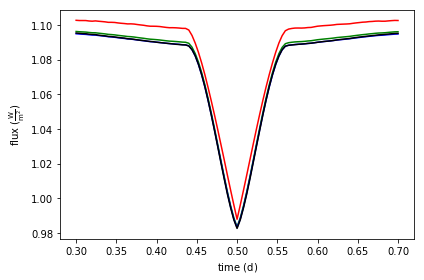

In [14]:
axs, artists = b.plot(model='ck2004',color='r')
axs, artists = b.plot(model='linear',color='g')
axs, artists = b.plot(model='quadratic',color='b')
axs, artists = b.plot(model='interp',color='k')

Clearly, in this case, the linear parameterisation deviates from the curves produced using 'interp' and the quadratic parameterisation (which agree reasonably well), while the curve which ignores limb-darkening is some way off!

# Exercise

Try adding a dataset in a different passband to see how the difference between model atmospheres and black bodies is wavelength dependent

For the next part, you might find the following convenience function useful.  It returns log g (in cgs units) for a given stellar and mass (both in solar units).  Note that the actual (mean) value for the stars in our 1 day period binary are likely to be a little larger, but this function should serve as a reasonable approximation for looking up tabulated limb-darkening parameters.

In [15]:
def logg(R,M=1.):
        g=c.G*M*u.Msun/((R*u.Rsun)**2)
        logg=np.log10(g.to(u.cm/u.s**2).value)
        return logg

For example, to find the log g of a 1.5 solar mass star with a radius of two solar radii.

In [16]:
logg(2,1.5)

4.012098895030852

Vary all the stellar parameters - temperature, radius, metallicity (the 'abun' parameter) and mass (it may be convenient to flip a constraint in order to vary the masses) - to explore the parameter space covered by the ck2004 atmosphere models (and interpolated limb-darkening).  You may also wish to change the gravity brightening/darkening coefficients depending on your particular parameters - you can use those suggested by PHOEBE or the tabulated values from, for example, [Claret & Bloemen (2011)](http://vizier.cfa.harvard.edu/viz-bin/VizieR?-source=J/A+A/529/A75) again.  If you compare your lightcurves using 'interp' limb-darkening to lightcurves using other parameterisation, remembers to update the coefficients every time you change the stellar parameters!